In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv
/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv
/kaggle/input/argugpt/argugpt.csv
/kaggle/input/argugpt/machine-dev.csv
/kaggle/input/argugpt/machine-test.csv
/kaggle/input/argugpt/machine-train.csv
/kaggle/input/transformers-model-downloader-pytorch-tf2-0/__results__.html
/kaggle/input/transformers-model-downloader-pytorch-tf2-0/__notebook__.ipynb
/kaggle/input/transformers-model-downloader-pytorch-tf2-0/__output__.json
/kaggle/input/transformers-model-downloader-pytorch-tf2-0/custom.css
/kaggle/input/transformers-model-downloader-pytorch-tf2-0/microsoft/d

## Import Necessary Library

In [2]:
import torch.nn.functional as F
from transformers import AutoModel
from transformers import AutoTokenizer
from tokenizers import Tokenizer, trainers, pre_tokenizers, models
from transformers import DebertaTokenizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
#import spacy
import re
import gc
# ----------
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Import Data
The notebook uses two datasets: **train_essays.csv** and **train_drcat_04.csv**. <br>
**train_essays.csv** is provided by the competition host, while the label is highly imbalanced.<br> **train_drcat_04.csv** is the dataset provided by one of the participants of the competition.

In [3]:
train_essays = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
external = pd.read_csv("/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv")
external

,essay_id,text,label,source,prompt,fold
0,E897534557AF,"In recent years, technology has had a profoun...",1,mistral7binstruct_v2,\nTask: Write an essay discussing the positive...,1
1,DFBA34FFE11D,Should students participate in an extracurricu...,0,persuade_corpus,NaN,2
2,af37ecf5,The electoral college is a symbol of mockery a...,0,train_essays,NaN,5
3,5EC2696BAD78,This is why I think the principle should allow...,0,persuade_corpus,NaN,8
4,llama_70b_v1843,I strongly believe that meditation and mindful...,1,llama_70b_v1,Some schools have implemented meditation and m...,0
...,...,...,...,...,...,...
44201,F7341069C4A4,"""Oh man I didn't make the soccer team!"", yelle...",0,persuade_corpus,NaN,7
44202,AFE6E553DAC2,I believe that using this technology could be ...,0,persuade_corpus,NaN,8
44203,falcon_180b_v1_600,The Face on Mars is a fascinating phenomenon t...,1,falcon_180b_v1,You have read the article 'Unmasking the Face ...,3
44204,A5F84C104693,Texting & Driving\n\nUsing your phone while dr...,0,persuade_corpus,NaN,1


In [4]:
df = pd.concat([
    external[external.source=="persuade_corpus"].sample(10000),
    external[external.source!='persuade_corpus']
])

In [5]:
df = df.reset_index()

In [6]:
df['stratify'] = df.label.astype(str)+df.source.astype(str)


In [7]:
import transformers 
print('transformers version:', transformers.__version__)

transformers version: 4.36.0


In [8]:
config = {
    'model': '/kaggle/input/transformers-model-downloader-pytorch-tf2-0/microsoft/deberta-v3-base',
    'dropout': 0.2,
    'max_length': 512,
    'batch_size':3,
    'epochs': 3,
    'lr': 1e-5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'scheduler': 'CosineAnnealingWarmRestarts'
}

In [9]:
train_df,val_df = train_test_split(df,test_size=0.2,random_state = 101,stratify=df['stratify'])
train_df, val_df = train_df.reset_index(), val_df.reset_index()
print('dataframe shapes:',train_df.shape, val_df.shape)

dataframe shapes: (22568, 9) (5642, 9)


In [10]:
#train_df,val_df = train_test_split(train_essays,test_size=0.2,random_state = 101)
#train_df, val_df = train_df.reset_index(), val_df.reset_index()
#print('dataframe shapes:',train_df.shape, val_df.shape)

In [11]:
tokenizer = AutoTokenizer.from_pretrained(config['model'])
tokenizer.train_new_from_iterator(train_essays['text'], 52000)

DebertaV2TokenizerFast(name_or_path='/kaggle/input/transformers-model-downloader-pytorch-tf2-0/microsoft/deberta-v3-base', vocab_size=16815, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=T

In [12]:
len(tokenizer)

128001

In [13]:
test_essays = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")

In [14]:
df

,index,essay_id,text,label,source,prompt,fold,stratify
0,13129,BD45F6A61711,The name of the boy was Luke Bomberger and he ...,0,persuade_corpus,NaN,0,0persuade_corpus
1,31675,276663841FCE,I think it is a good idea for community servic...,0,persuade_corpus,NaN,0,0persuade_corpus
2,38585,DFA350B72363,I agree that you should have to do extracurric...,0,persuade_corpus,NaN,2,0persuade_corpus
3,43375,C85366379E6E,Despite laws against it nearly 90% of American...,0,persuade_corpus,NaN,2,0persuade_corpus
4,27410,F2005C8BE57C,Cars are used everyday to get from one place t...,0,persuade_corpus,NaN,7,0persuade_corpus
...,...,...,...,...,...,...,...,...
28205,44190,falcon_180b_v1_261,I think it's a good idea for schools to have o...,1,falcon_180b_v1,Some schools have implemented policies that al...,0,1falcon_180b_v1
28206,44195,BDF13939FA26,Students often debate whether inactivity or s...,1,mistral7binstruct_v2,\nTask: Research the benefits of staying occup...,3,1mistral7binstruct_v2
28207,44197,1ed36fd42635_04112023,The Seagoing Cowboys program is an amazing opp...,1,darragh_claude_v6,NaN,5,1darragh_claude_v6
28208,44199,d8f15f7d,Advantages of Limiting Car Usage\n\nLimiting c...,1,radek_500,NaN,0,1radek_500


### Building Training Dataset and Loader

In [15]:
class EssayDataset:
    def __init__(self, df, config,tokenizer, is_test = False):   
        self.df = df
        self.tokenizer = tokenizer
        self.is_test = is_test
        self.config = config
    
    def token_start(self, idx):
        sample_text = self.df.loc[idx,'text']
        
        tokenized = tokenizer.encode_plus(sample_text,
                                          None,
                                          add_special_tokens=True,
                                          max_length= self.config['max_length'],
                                          truncation=True,
                                          padding="max_length"
                                         )
        
        inputs = {
           "input_ids": torch.tensor(tokenized['input_ids'],dtype=torch.long),
            "token_type_ids": torch.tensor(tokenized['token_type_ids'],dtype=torch.long),
            "attention_mask": torch.tensor(tokenized['attention_mask'],dtype = torch.long)
        } 
        
        return inputs
        
    
    def __getitem__(self,idx):
        
        input_text = self.token_start(idx)
        
        if self.is_test:
            return input_text
        
        else:
            labels = self.df.loc[idx,'label']
            targets = {'labels' : torch.tensor(labels,dtype = torch.float32)}
            
            return input_text,targets
        
    def __len__(self):
        return len(self.df)

In [16]:
train_ds = EssayDataset(train_df,config,tokenizer = tokenizer)
val_ds = EssayDataset(val_df,config,tokenizer = tokenizer)
test_ds = EssayDataset(test_essays,config,tokenizer = tokenizer,is_test = True)

In [17]:
train_loader = torch.utils.data.DataLoader(train_ds,
                          batch_size= config['batch_size'])
val_loader = torch.utils.data.DataLoader(val_ds,
                          batch_size= config['batch_size'])
test_loader = torch.utils.data.DataLoader(test_ds,
                          batch_size= config['batch_size'])

### Model
Fine tuning the deberta-v3-base model with new-added layers

In [18]:
import torch.nn as nn
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling,self).__init__()
        
    
    def forward(self,last_hidden_state, attention_mask):
        new_weight = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        final = torch.sum(new_weight*last_hidden_state,1)
        total_weight = new_weight.sum(1)
        total_weight = torch.clamp(total_weight, min = 1e-9)
        mean_embedding = final/total_weight
        
        return mean_embedding

In [19]:
import torch.nn as nn
class mymodel(nn.Module):
    
    def __init__(self,config):
        super(mymodel,self).__init__()
        
        self.model_name = config['model']
        self.deberta = AutoModel.from_pretrained(self.model_name)
#12801 = len(tokenizer)
        self.deberta.resize_token_embeddings(128001)
        self.dropout = nn.Dropout(config['dropout'])
        self.fn0 = nn.Linear(self.deberta.config.hidden_size,256)
        self.fn2 = nn.Linear(256,1)
        self.pooling = MeanPooling()
    
    def forward(self, input):
        output = self.deberta(**input,return_dict = True)
        output = self.pooling(output['last_hidden_state'],input['attention_mask'])
        output = self.dropout(output)
        output = self.fn0(output)
        output = self.dropout(output)
        output = self.fn2(output)
        output = torch.sigmoid(output)
        return output
        

In [20]:
class Trainer:
    
    def __init__(self,model,loaders,config):
        self.model = model
        self.train_loader,self.val_loader = loaders
        self.config = config
        self.input_keys = ['input_ids','token_type_ids','attention_mask']
        self.optim = self.__get__optim()
        self.scheduler_options = {
            'CosineAnnealingWarmRestarts': torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optim, T_0=5,eta_min=1e-7),
            'ReduceLROnPlateau': torch.optim.lr_scheduler.ReduceLROnPlateau(self.optim, 'min', min_lr=1e-7),
            'StepLR': torch.optim.lr_scheduler.StepLR(self.optim,step_size=2)
        }
        
        self.scheduler = self.scheduler_options[self.config['scheduler']]
        
        self.train_losses = []
        self.val_losses = []
        
    def __get__optim(self):
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.config['lr'])
        return optimizer
    
    
    def loss_fn(self,outputs,targets):
        criterion = nn.BCELoss()
        loss = criterion(outputs, targets)
        
        return loss
    
    
    
    def train_one_epoch(self,epoch):
        
        running_loss = 0
        
        progress = tqdm(self.train_loader,total=len(self.train_loader))
        
        for i,(inputs,targets) in enumerate(progress):
            
            self.optim.zero_grad()
            inputs = {k:inputs[k].to(device=config['device']) for k in inputs.keys()}
            targets = targets['labels'].to(device=config['device'])
            
            outputs= self.model(inputs)
            targets = targets.view(-1, 1)
            loss = self.loss_fn(outputs,targets)
            
            running_loss += loss.item()
            
            loss.backward()
            self.optim.step()
            self.scheduler.step()
            
            del inputs,targets
        
        train_loss = running_loss/len(self.train_loader)
        self.train_losses.append(train_loss)
        
        
    
    @torch.no_grad()
    def valid_one_epoch(self,epoch):
        
        running_loss = 0
        progress = tqdm(self.val_loader,total=len(self.val_loader))
        
        for (input, targets) in progress:
            
            input = {k: input[k].to(device = config['device']) for k in input.keys()}
            targets = targets['labels'].to(device = config['device'])
            
            outputs = self.model(input)
            targets = targets.view(-1, 1)
            loss = self.loss_fn(outputs,targets)
            running_loss += loss.item()
        
        val_loss = running_loss/len(self.val_loader)
        self.val_losses.append(val_loss)
        
        
    def test(self,test_loader):
        preds = []
        for (inputs) in test_loader:
            inputs = {k:inputs[k].to(device=config['device']) for k in inputs.keys()}
            
            outputs = self.model(inputs)
            preds.append(outputs.detach().cpu())
            
        preds = torch.concat(preds)
        return preds
    
    
    
    def fit(self):
        fit_progress = tqdm(
            range(1, self.config['epochs']+1),
            leave = True,
            desc="Training..."
        )
        
        for epoch in fit_progress:
            
            self.model.train()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']} | training...")
            self.train_one_epoch(epoch)
            self.clear()
            
            self.model.eval()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']} | validating...")
            self.valid_one_epoch(epoch)
            self.clear()

            print(f"{'-'*30} EPOCH {epoch} / {self.config['epochs']} {'-'*30}")
            print(f"train loss: {self.train_losses[-1]}")
            print(f"valid loss: {self.val_losses[-1]}\n\n")
            
    def clear(self):
        gc.collect()
        torch.cuda.empty_cache()
    
    
        

In [21]:
model = mymodel(config).to(device=config['device'])

In [22]:
trainer = Trainer(model, (train_loader,val_loader),config)

trainer.fit()

Training...:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7523 [00:00<?, ?it/s]

  0%|          | 0/1881 [00:00<?, ?it/s]

------------------------------ EPOCH 1 / 3 ------------------------------
train loss: 0.033995405763476226
valid loss: 0.09958051644072446




  0%|          | 0/7523 [00:00<?, ?it/s]

  0%|          | 0/1881 [00:00<?, ?it/s]

------------------------------ EPOCH 2 / 3 ------------------------------
train loss: 0.014825876981654192
valid loss: 0.031479226536189474




  0%|          | 0/7523 [00:00<?, ?it/s]

  0%|          | 0/1881 [00:00<?, ?it/s]

------------------------------ EPOCH 3 / 3 ------------------------------
train loss: 0.011395365815899776
valid loss: 0.021111860766725044




In [23]:
#trainer.save_model('trained_model.pth')
#tokenizer.save_pretrained('tokenizer.pth')

In [24]:
torch.save(model.state_dict(), 'my_model.pth')

In [25]:
#test_essays["generated"]= trainer.test(test_loader).numpy()
#test_essays = test_essays[["id","generated"]]
#test_essays.to_csv("submission.csv",index=False)

In [26]:
losses_df = pd.DataFrame({'epoch':list(range(1,config['epochs']+1)),
                         'train_loss':trainer.train_losses,
                         'val_loss':trainer.val_losses})

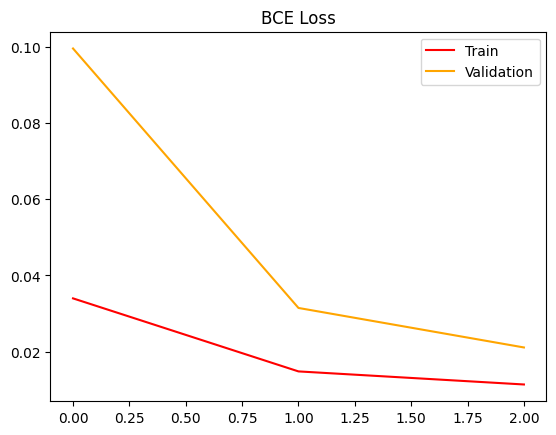

In [27]:
plt.plot(trainer.train_losses, color='red')
plt.plot(trainer.val_losses, color='orange')
plt.title('BCE Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

The model is later used to participate the Kaggle Competition:LLM - Detect AI Generated Text.
The Auc of the model is 0.75